### History of the Centre Frequency and Transmitter Calibrations

As we have the original fMRI QA images on the DICOM server we can look at historical trends in any other
paramters that can be extracted from the DICOM. For instance, we can plot the history of system calibrations by getting a slice from each QA run and extracting the data from the Siemens shadow data tags (nb we currently use the local package `dcmextras` for this but there are also facilities for reading `CSA` in the [nibabel](http://nipy.org/nibabel/) package.

In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

# Interface to query DICOM server for images
import dicom as dcm
from dcmfetch.queryinterface import QueryInterface, QIError
from dcmfetch.aettable import AetTable

import os
from datetime import datetime
from platform import node

# Assume a dcmnodes.cf with a 'Dcm4Chee' entry
qi = QueryInterface()
server = 'Dcm4Chee'
stationname = 'CRIC45064'

In [2]:
# Get one frame from the 20 minute protocol of each of the runs
from operator import attrgetter
matching_patients = sorted(qi.pat_level_find(server, '*', 'FMR*', '*', '*'), key=attrgetter('patid'))
print('Found %d candidate QA patients' % len(matching_patients))
seriess = []
for patid in [pat.patid for pat in matching_patients]:
    seriess += qi.combo_find(server, patid)
print('Found a total of %d series' % len(seriess))

# Then put in date order
seriess.sort(key=lambda s: s.studydate)
seriess = list(filter(lambda s: s.description == 'ep2d_fbirn_20min', seriess))
print('Found %d candidate series' % len(seriess))

# Uniqify series on studydate (should always take *last* one)
seriess = list({s.studydate: s for s in seriess}.values())
print('Found %d unique series' % len(seriess))

# Get image uids for first (could be any) frame
images = []
for series in seriess:
    images += qi.image_level_find(server, patid=series.patid, studyuid=series.studyuid, seriesuid=series.seriesuid)[:1]


Found 89 candidate QA patients
Found a total of 517 series
Found 95 candidate series
Found 84 unique series


In [3]:
# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
from glob import glob
from os.path import join as pjoin
tempdir = mkdtemp()

for (series, image) in zip(seriess, images):
    # NB Returns a generator hence list() to force iteration
    list(qi.image_level_fetch(server,
                          patid=series.patid, studyuid=series.studyuid, seriesuid=series.seriesuid, imageuid=image.imageuid,
                          savedir=tempdir))

dobjs = sorted(
    [dcm.read_file(f) for f in glob(pjoin(tempdir, '*'))],
    key=lambda d: d.AcquisitionDate
)

dobjs = [d for d in dobjs if 'StationName' in d and d.StationName == stationname]
print('Found %d scans for %s' % (len(dobjs), stationname))

rmtree(tempdir)

Found 83 scans for CRIC45064


Excitation:Reference = {1.0153799999999999}


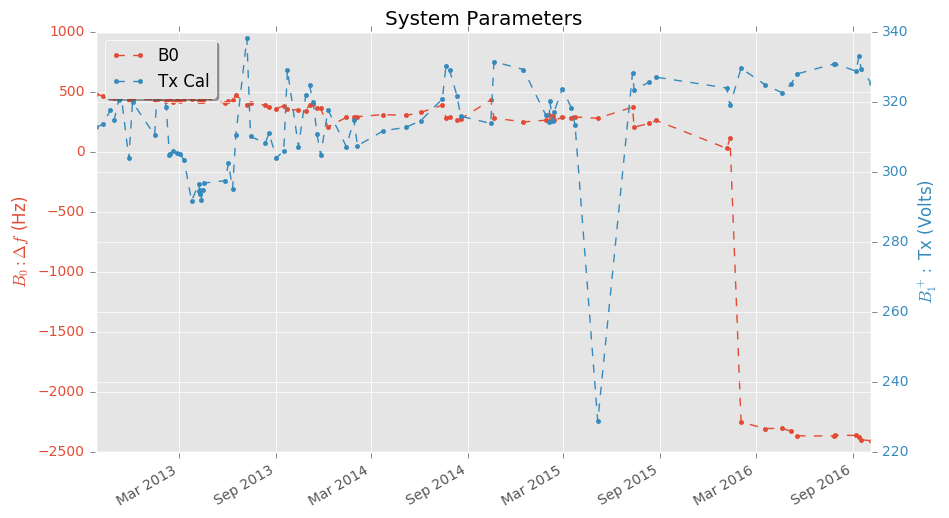

In [4]:
# Plot system data obtained from shadow headers etc
from dcmextras.siemenscsa import csa, phoenix

# Centre frequency
freqs = np.asarray([float(d.ImagingFrequency) for d in dobjs]) * 1000000

# Transmitter voltages
cal_voltages = np.asarray([float(csa(d)['TransmitterCalibration']) for d in dobjs])
fl_voltages = np.asarray([float(phoenix(d)['sTXSPEC.aRFPULSE[0].flAmplitude']) for d in dobjs])

# The voltage of the excitation pulse is a fixed ratio of the reference voltage
print('Excitation:Reference =', set(np.round(fl_voltages/cal_voltages, 5)))
dates = [datetime.strptime(d.AcquisitionDate, '%Y%m%d') for d in dobjs]

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(111)
l1 = ax1.plot_date(dates, freqs - np.mean(freqs), linestyle='dashed', marker='.')
ax1.grid(True)
ax1.set_ylabel(r'$B_0: \Delta f$ (Hz)', color=l1[0].get_color())
for tl in ax1.get_yticklabels():
    tl.set_color(l1[0].get_color())
fig.autofmt_xdate()

ax2 = ax1.twinx()
next(ax2._get_lines.prop_cycler)
l2 = ax2.plot(dates, cal_voltages, linestyle='dashed', marker='.')
ax2.set_ylabel(r'$B_1^+:$ Tx (Volts)', color=l2[0].get_color())
for tl in ax2.get_yticklabels():
    tl.set_color(l2[0].get_color())
plt.legend(l1 + l2, ['B0', 'Tx Cal'], shadow=True, fancybox=True, loc=2)
plt.title('System Parameters');

There seems to be little systematic drift in these. The field seems to be falling at only 10-20Hz a month - not much more than 1ppm a year except the 3kHz jump when the system was re-ramped. The Tx voltage, has risen only very gradually over time except for a single bad point.